# Working with Results

Train a DQN agent on CartPole, inspect the results object, save the config to disk, then reload and reproduce the exact same run.

In [1]:
import shutil
from pathlib import Path

import matplotlib.pyplot as plt

from myriad import (
    Config,
    config_to_eval_config,
    create_config,
    create_eval_config,
    evaluate,
    load_config,
    save_config,
    train_and_evaluate,
)
from myriad.utils.rendering import render_saved_episodes
from myriad.utils.plotting import plot_training_curve

from _helpers import side_by_side_videos

## Train DQN

Same config as tutorial 02, but with episode saving enabled. This saves one episode per eval checkpoint (every 500 steps) to `./episodes/step_{N}/episode_0.npz`.

In [2]:
config = create_config(
    env="cartpole-control",
    agent="dqn",
    num_envs=128,
    steps_per_env=5000,
    eval_frequency=500,
    log_frequency=500,
    eval_rollouts=50,
    seed=0,
    epsilon_decay_steps=2000,
    target_network_frequency=100,
    scan_chunk_size=500,
    # Enable episode saving
    eval_episode_save_frequency=500,  # Save every 500 steps (at each eval checkpoint)
    eval_episode_save_count=1,  # Save only 1 episode per checkpoint
)
results = train_and_evaluate(config)
print(results)

Training: 100%|██████████| 5000/5000 [00:01<00:00, 2883.39steps/s] , loss=0.064, eval_return=500.00

TrainingResults(
  final_eval_return=500.0 ± 0.0,
  steps_per_env=5,000,
  global_steps=640,000,
  num_evals=10
)


## Inspect Results

`TrainingResults` bundles everything from the run: trained agent state, evaluation metrics at each checkpoint, training loss history, and the config used.

In [3]:
# Summary dict of key metrics
results.summary()

{'final_eval_return_mean': 500.0,
 'final_eval_return_std': 0.0,
 'training_steps_per_env': 5000,
 'training_global_steps': 640000,
 'num_eval_checkpoints': 10}

In [4]:
# All results available
print("Training metrics: ", list(results.training_metrics.__dict__.keys()))
print("Evaluation metrics: ", list(results.eval_metrics.__dict__.keys()))
print("Agent state: ", list(results.agent_state.__dict__.keys()))
print("Final environment state: ", list(results.final_env_state.__dict__.keys()))
print("Run configuration: ", results.config)

Training metrics:  ['global_steps', 'steps_per_env', 'loss', 'reward', 'agent_metrics']
Evaluation metrics:  ['global_steps', 'steps_per_env', 'episode_returns', 'episode_lengths', 'mean_return', 'std_return', 'mean_length']
Agent state:  ['train_state', 'target_params', 'global_step']
Final environment state:  ['env_state', 'obs']
Run configuration:  run=RunConfig(seed=0, eval_rollouts=50, eval_max_steps=500, eval_episode_save_frequency=500, eval_episode_save_count=1, eval_render_videos=False, eval_video_fps=50, steps_per_env=5000, num_envs=128, scan_chunk_size=500, buffer_size=10000, rollout_steps=None, eval_frequency=500, log_frequency=500) agent=AgentConfig(name='dqn', batch_size=32, epsilon_decay_steps=2000, target_network_frequency=100) env=EnvConfig(name='cartpole-control') wandb=WandbConfig(enabled=False, project='myriad', entity=None, group=None, job_type='train', run_name=None, mode='offline', dir=None, tags=())


In [5]:
# Mean return at each eval checkpoint
print("Eval steps:", results.eval_metrics.steps_per_env)
print("Mean return:", results.eval_metrics.mean_return)

# Raw episode returns from the 3rd checkpoint
print(f"\nThird checkpoint ({len(results.eval_metrics.episode_returns[2])} episodes):")
print(results.eval_metrics.episode_returns[2])

Eval steps: [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
Mean return: [18.760000228881836, 219.0800018310547, 275.1400146484375, 260.8599853515625, 146.13999938964844, 219.72000122070312, 154.47999572753906, 142.75999450683594, 192.5399932861328, 500.0]

Third checkpoint (50 episodes):
[273. 244. 275. 219. 222. 233. 227. 252. 206. 489. 228. 200. 311. 198.
 239. 207. 231. 378. 251. 500. 244. 337. 330. 263. 223. 215. 194. 477.
 200. 396. 211. 258. 306. 237. 203. 280. 215. 249. 271. 327. 321. 245.
 234. 278. 500. 274. 221. 333. 257. 275.]


In [6]:
# Training loss history
print("# of loss checkpoints:", len(results.training_metrics.loss))
print("Final loss:", f"{results.training_metrics.loss[-1]:.4f}")

# of loss checkpoints: 10
Final loss: 0.0637


In [7]:
# Examples of additional agent-specific metrics
print("Final DQN Q value: ", results.training_metrics.agent_metrics["q_value"][-1])
print("Final DQN TD error: ", results.training_metrics.agent_metrics["td_error"][-1])

Final DQN Q value:  41.415489196777344
Final DQN TD error:  0.20919108390808105


## Visualize Learning Progress

Render episodes from the 1st, 5th, and 10th evaluation checkpoints (steps 500, 2500, 5000) to see how the policy evolves during training.

In [8]:
# Render episodes from 1st, 5th, and 10th eval checkpoints
steps_labels = [(500, "Early"), (2500, "Mid"), (5000, "Final")]

video_paths, episode_data = render_saved_episodes(
    env_name="cartpole-control",
    steps=[s for s, _ in steps_labels],
    fps=50,
)

# Create labels with return information from episode data
video_labels = []
for i, ((step, label), path, data) in enumerate(zip(steps_labels, video_paths, episode_data)):
    episode_return = float(data["episode_return"])
    video_labels.append(f"{label} ({step} steps)\nReturn: {episode_return:.0f}")

side_by_side_videos(video_paths, video_labels, width=300)

## Plot Learning Curve

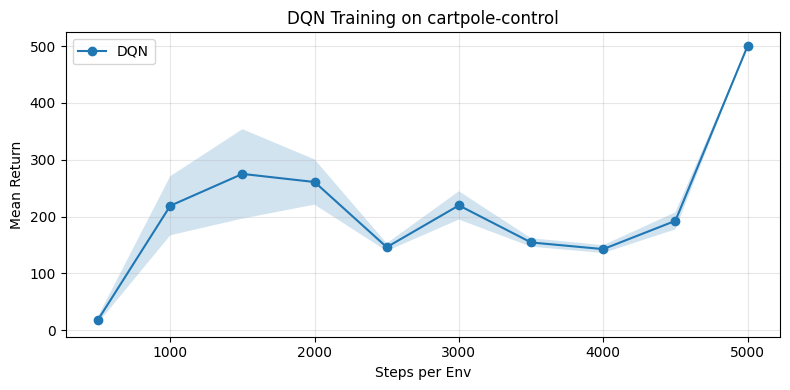

In [9]:
fig, ax = plot_training_curve(results)
plt.show()

## Evaluate a Trained Agent

Convert the training config to an eval config and re-evaluate the trained agent. Compare against a bang-bang baseline on the same task.

In [17]:
# Evaluate trained DQN
eval_config = config_to_eval_config(results.config)
dqn_eval = evaluate(eval_config, agent_state=results.agent_state)
print("Trained DQN:", dqn_eval)

# PID baseline for comparison
pid_config = create_eval_config(
    env="cartpole-control",
    agent="bangbang",
    obs_field="theta",
    eval_rollouts=eval_config.run.eval_rollouts,
    seed=0,
)
pid_eval = evaluate(pid_config)
print("\nBang-bang baseline:", pid_eval)

Trained DQN: EvaluationResults(
  mean_return=500.0 ± 0.0,
  range=[500.0, 500.0],
  mean_length=500.0,
  num_episodes=50
)

Bang-bang baseline: EvaluationResults(
  mean_return=40.1 ± 6.9,
  range=[25.0, 59.0],
  mean_length=40.1,
  num_episodes=50
)


## Save Config to Disk

Persist the full training config as YAML. This captures everything needed to reproduce the run: environment, agent, hyperparameters, and seed.

In [ ]:
save_config(results.config, "my_run/config.yaml")

print("Saved:")
for p in sorted(Path("my_run").iterdir()):
    print(f"  {p.name:20s} {p.stat().st_size:,} bytes")

print("\n--- config.yaml ---")
print(Path("my_run/config.yaml").read_text())

## Reproduce from Saved Config

Reload the config from disk and retrain. JAX's functional paradigm guarantees determinism — same config and seed produces identical results.

In [ ]:
loaded_config = load_config("my_run/config.yaml", Config)
reproduced = train_and_evaluate(loaded_config)

print("Original returns: ", results.eval_metrics.mean_return)
print("Reproduced returns:", reproduced.eval_metrics.mean_return)
assert results.eval_metrics.mean_return == reproduced.eval_metrics.mean_return
print("\nIdentical.")

## Seed Reproducibility

A different seed produces a different training trajectory, but the same seed always reproduces exactly.

In [ ]:
config_seed1 = create_config(
    env="cartpole-control",
    agent="dqn",
    num_envs=128,
    steps_per_env=5000,
    eval_frequency=500,
    log_frequency=500,
    eval_rollouts=50,
    seed=1,
    epsilon_decay_steps=2000,
    target_network_frequency=100,
    scan_chunk_size=500,
)
results_seed1 = train_and_evaluate(config_seed1)

print("Seed 0 final return:", results.eval_metrics.mean_return[-1])
print("Seed 1 final return:", results_seed1.eval_metrics.mean_return[-1])
print("\nDifferent seeds produce different training trajectories (but both converge).")

## Cleanup

In [ ]:
shutil.rmtree("my_run")
shutil.rmtree("episodes")
shutil.rmtree("videos")